<a href="https://colab.research.google.com/github/YassineSdk/Coran_recitation_classification_with_Pytorch/blob/main/Coran_recitation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing the data**

In [181]:
! pip install opendatasets --quiet

In [182]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Skipping, found downloaded files in "./quran-recitations-for-audio-classification" (use force=True to force download)


### **loading the Packages**

In [183]:
import torch
from torch import nn
from torch.optim import Adam
import librosa
from torch.utils.data import Dataset , DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize
import seaborn as sns
sns.set_style('white')
device = "cuda" if torch.cuda.is_available() else "cpu"
print("the device we are using is ",device)
import warnings
warnings.filterwarnings('ignore')

the device we are using is  cuda


### **Data Preprocessing and Cleaning**

In [184]:
df = pd.read_csv('/content/quran-recitations-for-audio-classification/files_paths.csv')
df.head()

,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan


Text(0.5, 1.0, 'counts of Classes')

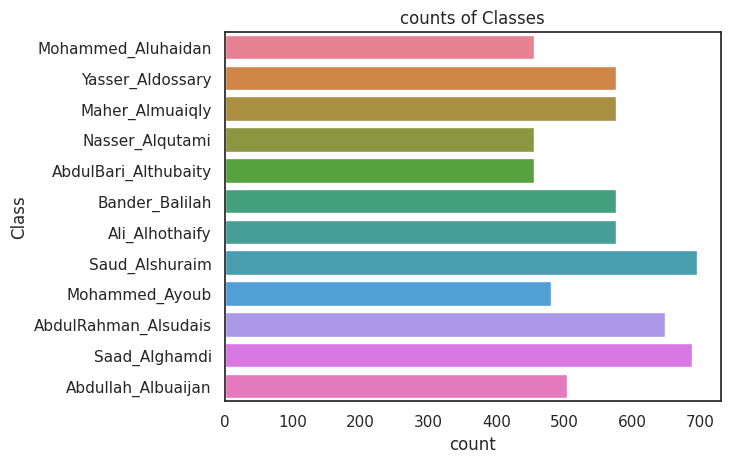

In [185]:
sns.countplot(y=df['Class'],hue=df['Class'])
plt.title('counts of Classes')

In [186]:
".hhhhhh"[1:]

'hhhhhh'

In [187]:
df['FilePath'] = '/content/quran-recitations-for-audio-classification/Dataset' + df['FilePath'].str[1:]

In [188]:
df.iloc[1,0]

'/content/quran-recitations-for-audio-classification/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_159.wav'

In [189]:
print("number of observation :",df.shape[0])
print("number of Dimensions :",df.shape[1])

number of observation : 6687
number of Dimensions : 2


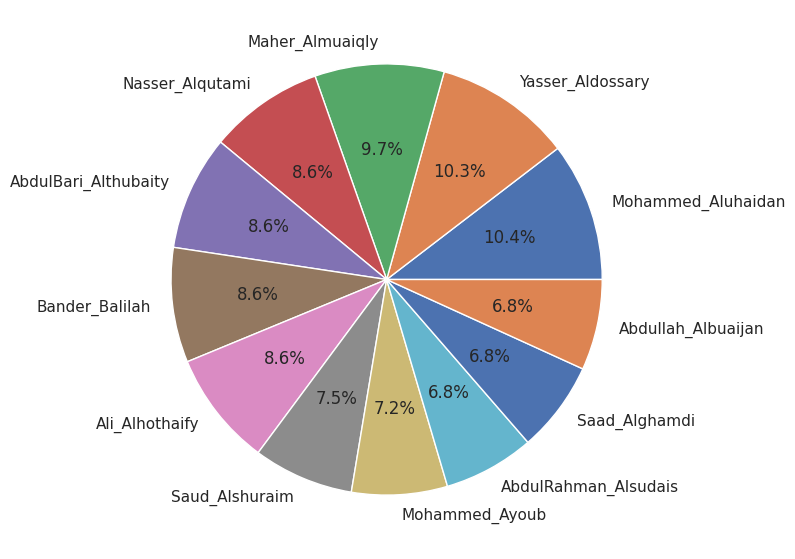

In [190]:
plt.figure(figsize=(7,7))
plt.pie(df['Class'].value_counts(),labels=df['Class'].unique(),autopct='%1.1f%%')
plt.show()

In [191]:
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])

In [192]:
df = df.sample(frac=1,random_state=42)
train = df.sample(frac=0.7,random_state=42)
test = df.drop(train.index)
val = test.sample(frac=0.5,random_state=42)
test = test.drop(val.index)

print('Training data shape:',train.shape[0])
print('validation data shape:',val.shape[0])
print('Testing data shape:',test.shape[0])

Training data shape: 4681
validation data shape: 1003
Testing data shape: 1003


### **Creating Custom Data**

In [245]:
original_labels = encoder.inverse_transform(df['Class'])
print(original_labels)


[ 6  0  9 ...  1  1 11]


In [226]:
encoder = LabelEncoder()
encoder = encoder.fit(df['Class'])
class Custom_audio_data(Dataset):
  def __init__(self,dataframe):
    self.dataframe = dataframe
    self.labels = torch.LongTensor(list(dataframe['Class'])).type(torch.LongTensor).to(device)
    self.audios = [torch.Tensor(self.get_spectogram(file_path)).type(torch.FloatTensor) for file_path in self.dataframe["FilePath"]]
  def __len__(self):
    return self.dataframe.shape[0]
  def __getitem__(self, index):
    image_path = self.dataframe.iloc[index,0]
    label = torch.Tensor(self.labels[index]).to(device)
    audio =  self.audios[index].unsqueeze(0).to(device)
    return audio , label
  def get_spectogram(self,file_path):
    sr = 22050
    duration = 5

    image_h = 128
    image_w = 256

    signal,sr = librosa.load(file_path,sr=sr,duration=duration)
    spectogram = librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=2048,hop_length=512,n_mels=128)
    spec_db = librosa.power_to_db(spectogram, ref = np.max)

    spec_resized = librosa.util.fix_length(spec_db,size=(duration * sr)//512+1)
    spec_resized = resize(spec_resized,(image_h,image_w),anti_aliasing=True)
    return spec_resized

  def plot_spectrogram(self, index):
    # Get the spectrogram for a given index
    audio_sample = self.audios[index].squeeze(0).cpu().numpy()  # Convert to NumPy for plotting

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    plt.imshow(audio_sample, aspect='auto', origin='lower', cmap='inferno')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for Index {index}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

In [228]:
train_data = Custom_audio_data(dataframe=train)
test_data = Custom_audio_data(dataframe=test)
val_data = Custom_audio_data(dataframe=val)

In [244]:
encoder.inverse_transform([2])

array([2])

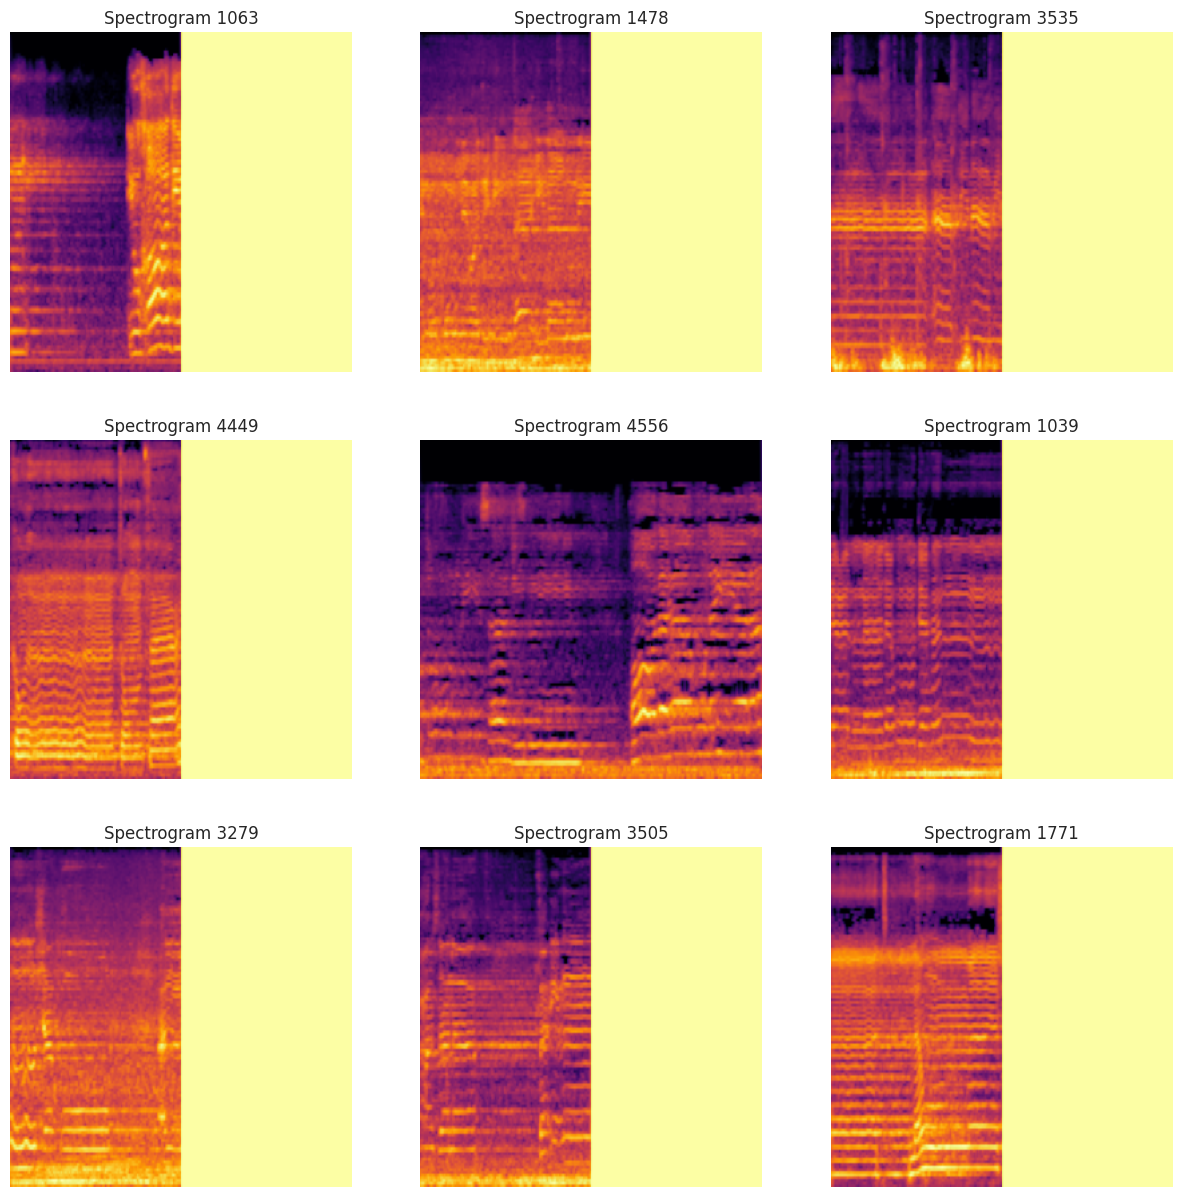

In [237]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))  # Increase the figsize for better visibility
ax = ax.flatten()
for i in range(len(ax)):
    idx = np.random.randint(0, len(train_data))  # Get a random index from the dataset
    ax[i].imshow(train_data[idx][0].squeeze(0).cpu().numpy(), aspect='auto', origin='lower', cmap='inferno')
    label = train_data[idx][1]
    ax[i].set_title(f'Spectrogram {}')
    ax[i].axis('off')

In [207]:
lr = 1e-4
Batch_size = 16
epochs = 25

In [212]:
train_loader = DataLoader(train_data,batch_size=Batch_size,shuffle=True)
val_loader = DataLoader(val_data,batch_size=Batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=Batch_size,shuffle=True)

In [ ]:
class audio_model(nn.Module)